# Iris Species Classification
This notebook implements a simple neural network to classify iris species based on the famous iris dataset. The dataset contains 150 samples of iris flowers, each with 4 features: sepal length, sepal width, petal length, and petal width. The flowers are classified into 3 species: setosa, versicolor, and virginica.

The dataset is available on Kaggle at:
> https://www.kaggle.com/datasets/uciml/iris

### Imports
Some libraries will be needed to run this notebook. The libraries are:
> pandas, to read the CSV files and manipulate the data.

> torch, to create the model, train it and evaluate it.

> sklearn, to split the dataset into training and test sets, scale and classify the model.

> matplotlib, to plot the data and some model metrics.

In [1]:
import pandas as pd

import torch
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

### Data Exploration

It is important to understand the data before building a model. The first step is to read the CSV file and create a pandas dataframe with the data.

In [2]:
df = pd.read_csv('iris.csv')
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
df.shape

(150, 6)

Here are shown some scatter plots, they help to visualize the data and understand the relationship between the features and their classes.

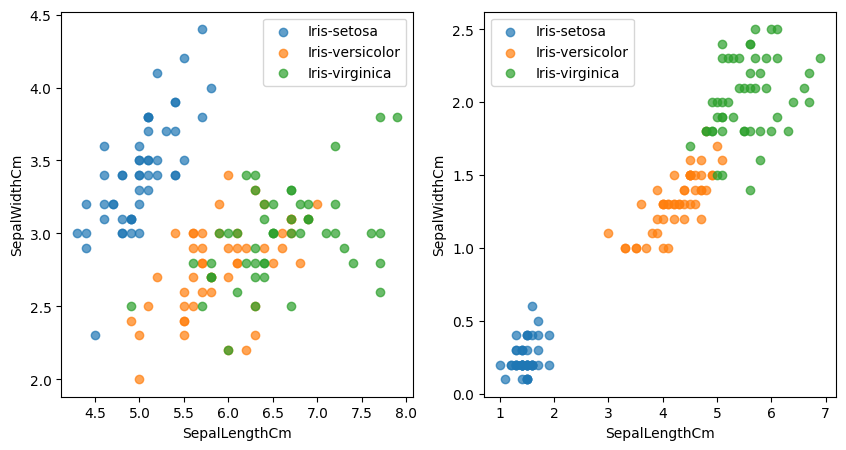

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

for species in df['Species'].unique():
    ax1.scatter(df[df['Species'] == species]['SepalLengthCm'], df[df['Species'] == species]['SepalWidthCm'], alpha=0.7, label=species)
    ax1.set_xlabel('SepalLengthCm')
    ax1.set_ylabel('SepalWidthCm')
    ax2.scatter(df[df['Species'] == species]['PetalLengthCm'], df[df['Species'] == species]['PetalWidthCm'], alpha=0.7, label=species)
    ax2.set_xlabel('SepalLengthCm')
    ax2.set_ylabel('SepalWidthCm')
    
ax1.legend()
ax2.legend()

plt.show()

Checking for missing values... there are none.

In [5]:
df.isnull().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

Outliers can embaise the model, so it is important to check for them. The boxplot shows that there are no outliers in the data.

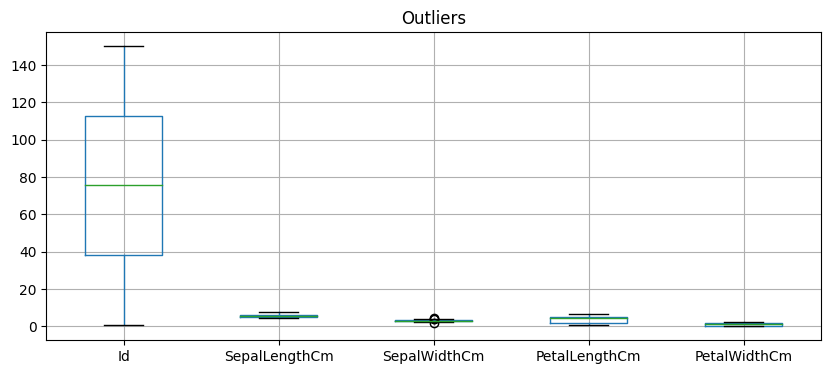

In [6]:
fig, ax = plt.subplots(figsize=(10, 4))

df.boxplot()
ax.set_title('Outliers')

plt.show()

Splittig the data into features and labels.

In [7]:
X = df.drop(['Id', 'Species'], axis=1)
y = df['Species']

X.shape, y.shape

((150, 4), (150,))

In [8]:
X.sample(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
129,7.2,3.0,5.8,1.6
73,6.1,2.8,4.7,1.2
11,4.8,3.4,1.6,0.2
2,4.7,3.2,1.3,0.2


Because we are dealing with multiclass classification, we need to turn our label into a one-hot encoded vector.

In [9]:
y_categorical = y.copy()

y = pd.get_dummies(y, columns=['Species'], dtype=float)
y.sample(5)

,Iris-setosa,Iris-versicolor,Iris-virginica
119,0.0,0.0,1.0
69,0.0,1.0,0.0
142,0.0,0.0,1.0
26,1.0,0.0,0.0
13,1.0,0.0,0.0


Scaling the features is important to improve the model performance.

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.sample(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
30,-1.264185,0.106445,-1.227541,-1.312977
104,0.795669,-0.124958,1.160819,1.316483
73,0.310998,-0.587764,0.535296,0.001753
15,-0.173674,3.114684,-1.284407,-1.050031
21,-0.900681,1.494863,-1.284407,-1.050031


Splittig the data into training and test sets.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=9)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120, 3), (30, 3))

As Pytorch works with tensors, we need to convert our data into tensors.

In [12]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_train = torch.from_numpy(y_train.to_numpy()).float()
y_test = torch.from_numpy(y_test.to_numpy()).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([120, 4]),
 torch.Size([30, 4]),
 torch.Size([120, 3]),
 torch.Size([30, 3]))

### Model

Our model will have 4 input neurons, 3 hidden layers, and 3 output neurons. The activation function used is the ReLU, except for the output layer, which uses the softmax function if we decide to predict something.

In [13]:
class IrisClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(input_size, out_features=8), nn.ReLU(),
                                 nn.Linear(8, 16), nn.ReLU(),
                                 nn.Linear(16, 8), nn.ReLU(),
                                 nn.Linear(8, output_size))
        
        # self.layer1 = nn.Linear(input_size, out_features=8)
        # self.layer2 = nn.Linear(8, 16)
        # self.layer3 = nn.Linear(16, 8)
        # self.layer4 = nn.Linear(8, output_size)
        
    def forward(self, x):
        return self.net(x)
    
    def predict(self, x):
        x = self.forward(x)
        return torch.argmax(nn.Softmax(dim= 1)(x), axis= 1)

A manual seed is set to avoid different results between equal runs.

In [14]:
torch.manual_seed(9)
in_features = X_train.shape[1]
out_features = y_train.shape[1]
model_0 = IrisClassifier(in_features, out_features)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.01)

In [15]:
def train(model, max_epochs, loss_fn, optimizer):
    train_loss_list = []
    test_loss_list = []
    
    for epoch in range(1, max_epochs+1):
        model.train()
        y_pred = model(X_train)
        
        loss = loss_fn(y_pred, y_train)
        train_loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.inference_mode():
            y_pred_test = model(X_test)
            test_loss = loss_fn(y_pred_test, y_test)
            test_loss_list.append(test_loss.item())

        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train loss: {loss.item()} | Test loss: {test_loss.item()}")
            
    fig, ax = plt.subplots(figsize=(10,6))

    ax.plot(train_loss_list, label='Train loss')
    ax.plot(test_loss_list, label='Test loss')
    ax.set_title("Loss value during training")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss (CrossEntropy)')
    ax.legend()

Epoch: 10 | Train loss: 0.9525811076164246 | Test loss: 0.9523179531097412
Epoch: 20 | Train loss: 0.7176446914672852 | Test loss: 0.6875713467597961
Epoch: 30 | Train loss: 0.45183074474334717 | Test loss: 0.3720308840274811
Epoch: 40 | Train loss: 0.29816848039627075 | Test loss: 0.19309253990650177
Epoch: 50 | Train loss: 0.18054048717021942 | Test loss: 0.08327225595712662
Epoch: 60 | Train loss: 0.08805929869413376 | Test loss: 0.022842658683657646
Epoch: 70 | Train loss: 0.055473197251558304 | Test loss: 0.004001542925834656
Epoch: 80 | Train loss: 0.04679922014474869 | Test loss: 0.001386177376843989
Epoch: 90 | Train loss: 0.04393240436911583 | Test loss: 0.0006603273213841021
Epoch: 100 | Train loss: 0.042549245059490204 | Test loss: 0.0004369239031802863
Epoch: 110 | Train loss: 0.04179709777235985 | Test loss: 0.0003276407951489091
Epoch: 120 | Train loss: 0.04086809605360031 | Test loss: 0.00027622279594652355
Epoch: 130 | Train loss: 0.03958725929260254 | Test loss: 0.0002

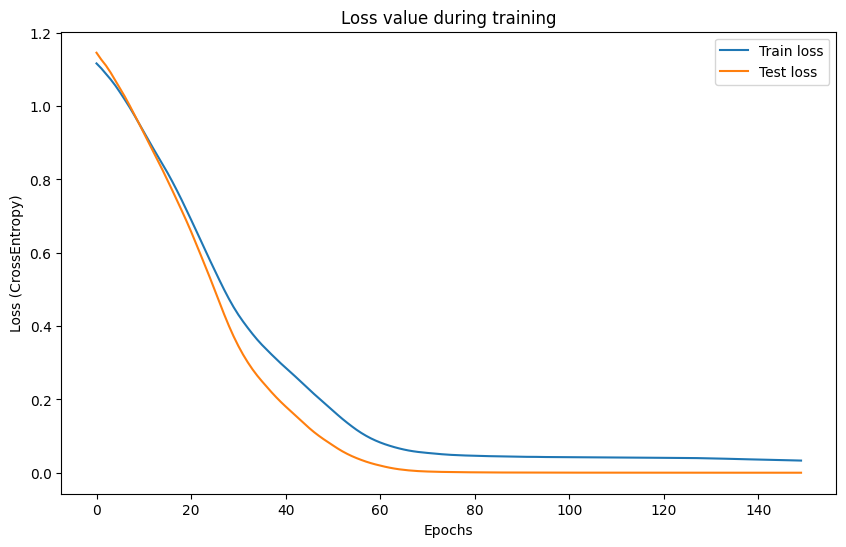

In [16]:
max_epochs = 150

train(model_0, max_epochs, loss_fn, optimizer)

In [17]:
y_categorical = []
for cl in y_test:
    y_categorical.append(torch.argmax(cl).item())

Overall, the model had a great performance, with an accuracy of 100% on the validation set. I believe that the training loop could have been smaller.

In [18]:
model_0.eval()
with torch.inference_mode():
    y_pred = model_0.predict(X_test).detach().numpy()
    print(classification_report(y_categorical, y_pred))
    

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         8

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

